In [7]:
import functools
from typing import Callable

import pandas as pd

from experiment_util import run_experiment, ModelBuilder
from edgedroid.models import timings
import numpy as np

window_size = 8
ttf_bins = 6
cleanup = timings.CleanupMode.TRUNCATE

num_steps = 100
num_reps = 40

def build_realistic_empirical(high_neuro: bool) -> tuple[str, timings.ExecutionTimeModel]:
    kernel = timings.LinearTTFWindowKernel(window_size=window_size, max_relative_weight=10)
    model = timings.EmpiricalETM(kernel=kernel, neuroticism=1.0 if high_neuro else 0.0, ttf_levels=ttf_bins, cleanup=cleanup)
    name = f"Realistic ({'high' if high_neuro else 'low'} neuro)"
    return name, model

def build_realistic_empirical_mean(high_neuro: bool) -> tuple[str, timings.ExecutionTimeModel]:
    kernel = timings.LinearTTFWindowKernel(window_size=window_size, max_relative_weight=10)
    model = timings.EmpiricalAggregateETM(aggregate_fn=np.mean, kernel=kernel, neuroticism=1.0 if high_neuro else 0.0, ttf_levels=ttf_bins, cleanup=cleanup)
    name = f"Realistic Mean ({'high' if high_neuro else 'low'} neuro)"
    return name, model

def build_realistic_fitted(high_neuro: bool) -> tuple[str, timings.ExecutionTimeModel]:
    kernel = timings.LinearTTFWindowKernel(window_size=window_size, max_relative_weight=10)
    model = timings.FittedETM(kernel=kernel, neuroticism=1.0 if high_neuro else 0.0, ttf_levels=ttf_bins, cleanup=cleanup)
    name = f"Realistic Fitted ({'high' if high_neuro else 'low'} neuro)"
    return name, model

def high_neuro(builder_fn: Callable[[bool], tuple[str, timings.ExecutionTimeModel]]) -> ModelBuilder:
    return functools.partial(builder_fn, high_neuro=True)

def low_neuro(builder_fn: Callable[[bool], tuple[str, timings.ExecutionTimeModel]]) -> ModelBuilder:
    return functools.partial(builder_fn, high_neuro=False)

def build_legacy() -> tuple[str, timings.ExecutionTimeModel]:
    kernel = timings.LinearTTFWindowKernel(window_size=window_size, max_relative_weight=10)
    model = timings.LegacyETM(kernel, ttf_levels=ttf_bins)
    name = "Legacy"
    return name, model

def build_baseline() -> tuple[str, timings.ExecutionTimeModel]:
    return "Baseline", timings.FirstOrderETM()

def low_ttf_seq_builder() -> list[float]:
    return [0.1] * num_steps

def mid_ttf_seq_builder() -> list[float]:
    return [1.6] * num_steps

def high_ttf_seq_builder() -> list[float]:
    return [3.0] * num_steps

low_ttf_results = run_experiment(
    model_builders=[
        high_neuro(build_realistic_empirical),
        low_neuro(build_realistic_empirical),
        high_neuro(build_realistic_empirical_mean),
        low_neuro(build_realistic_empirical_mean),
        high_neuro(build_realistic_fitted),
        low_neuro(build_realistic_fitted),
        build_legacy,
        build_baseline,
    ],
    ttf_seq_builder=low_ttf_seq_builder,
    reps_per_setup=num_reps,
)
low_ttf_results["ttf_level"] = "low"

mid_ttf_results = run_experiment(
    model_builders=[
        high_neuro(build_realistic_empirical),
        low_neuro(build_realistic_empirical),
        high_neuro(build_realistic_empirical_mean),
        low_neuro(build_realistic_empirical_mean),
        high_neuro(build_realistic_fitted),
        low_neuro(build_realistic_fitted),
        build_legacy,
        build_baseline,
    ],
    ttf_seq_builder=mid_ttf_seq_builder,
    reps_per_setup=num_reps,
)
mid_ttf_results["ttf_level"] = "mid"

high_ttf_results = run_experiment(
    model_builders=[
        high_neuro(build_realistic_empirical),
        low_neuro(build_realistic_empirical),
        high_neuro(build_realistic_empirical_mean),
        low_neuro(build_realistic_empirical_mean),
        high_neuro(build_realistic_fitted),
        low_neuro(build_realistic_fitted),
        build_legacy,
        build_baseline,
    ],
    ttf_seq_builder=high_ttf_seq_builder,
    reps_per_setup=num_reps,
)
high_ttf_results["ttf_level"] = "high"

results = pd.concat((low_ttf_results, mid_ttf_results, high_ttf_results))

for col in ["run_id", "model_name"]:
    results[col] = results[col].astype("category")
    
results["ttf_level"] = results["ttf_level"].astype(pd.CategoricalDtype(["low", "mid", "high"], ordered=True))

results.to_parquet("./fixed_ttf_results.parquet")
results

,run_id,model_name,prev_ttf,step_index,exec_time,step_time,task_duration,ttf_level
0,66b71bd61a8d43f5837cd651ab05030c,Baseline,0.0,0,5.181394,5.231394,5.231394,low
1,66b71bd61a8d43f5837cd651ab05030c,Baseline,0.1,1,5.977476,6.027476,11.258870,low
2,66b71bd61a8d43f5837cd651ab05030c,Baseline,0.1,2,8.567804,8.617804,19.876674,low
3,66b71bd61a8d43f5837cd651ab05030c,Baseline,0.1,3,8.400484,8.450484,28.327157,low
4,66b71bd61a8d43f5837cd651ab05030c,Baseline,0.1,4,4.992943,5.042943,33.370100,low
...,...,...,...,...,...,...,...,...
95,62959e6bfaa44c668038888186096f04,Realistic Fitted (low neuro),3.0,95,3.551395,5.051395,648.791505,high
96,62959e6bfaa44c668038888186096f04,Realistic Fitted (low neuro),3.0,96,6.001728,7.501728,656.293233,high
97,62959e6bfaa44c668038888186096f04,Realistic Fitted (low neuro),3.0,97,5.599568,7.099568,663.392801,high
98,62959e6bfaa44c668038888186096f04,Realistic Fitted (low neuro),3.0,98,6.208499,7.708499,671.101299,high


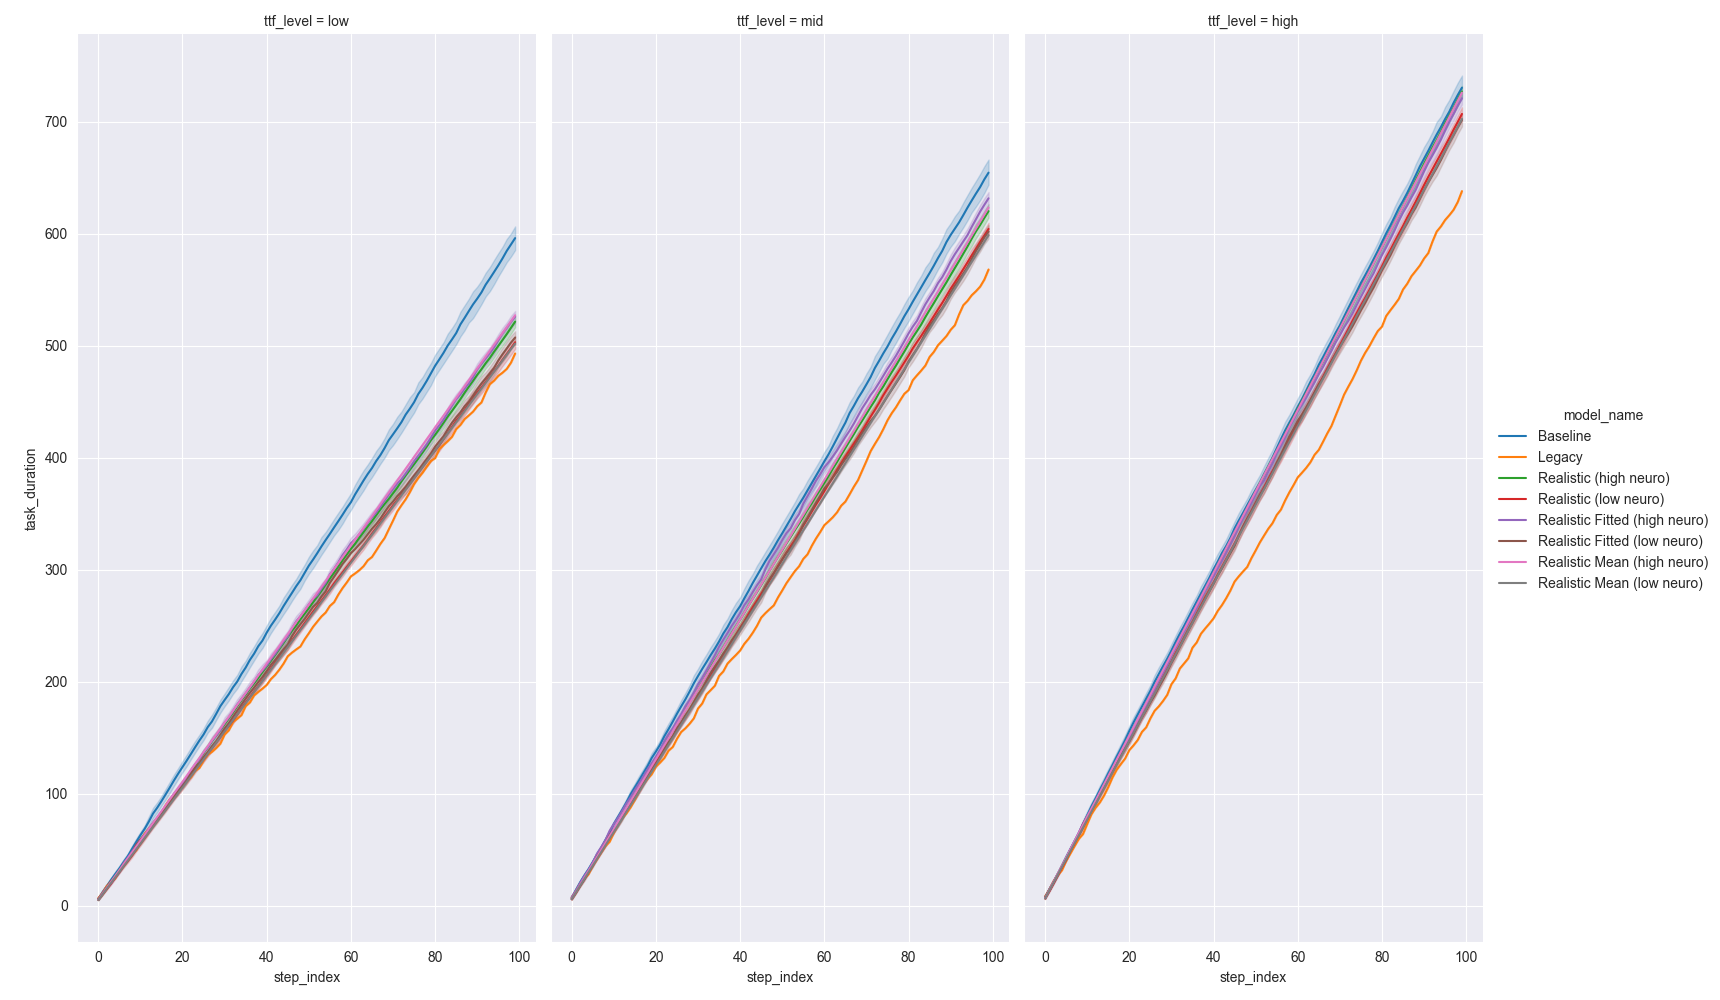

In [13]:
%matplotlib widget

import matplotlib.pyplot as plt
import seaborn as sns

fg = sns.relplot(data=results, kind="line", x="step_index", y="task_duration", hue="model_name", col="ttf_level", height=10, aspect=0.5)
plt.show()

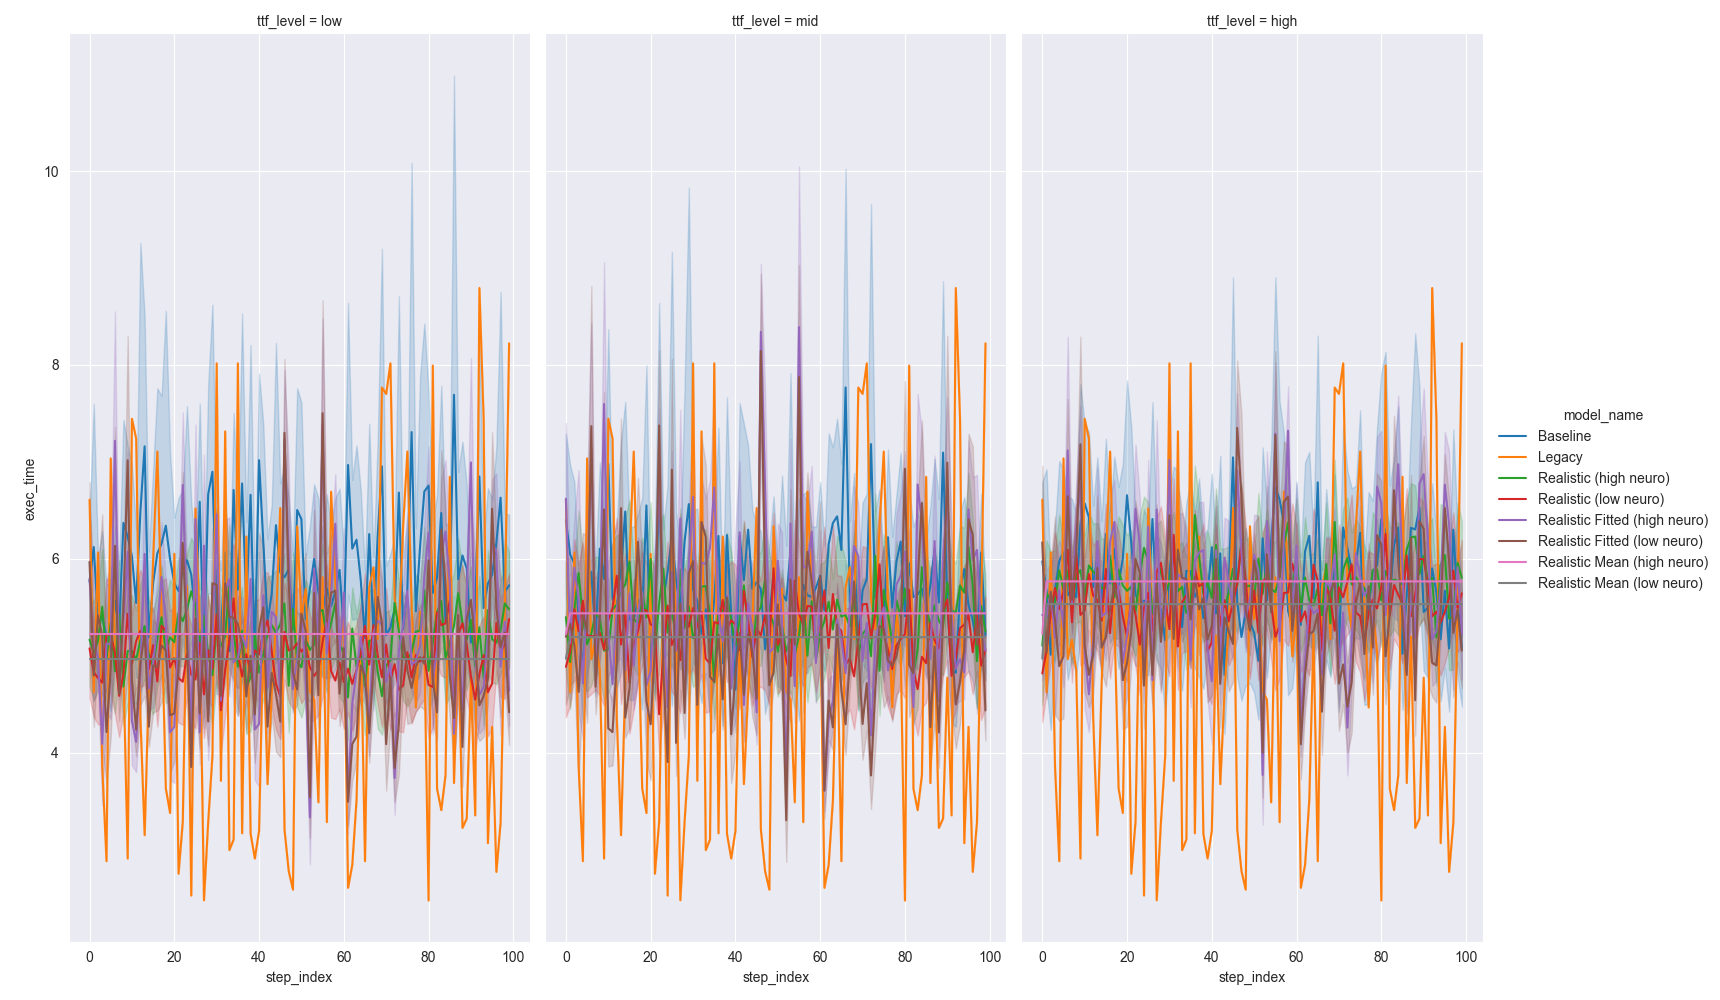

In [14]:
fg = sns.relplot(data=results, kind="line", x="step_index", y="exec_time", hue="model_name", col="ttf_level", height=10, aspect=0.5)
plt.show()

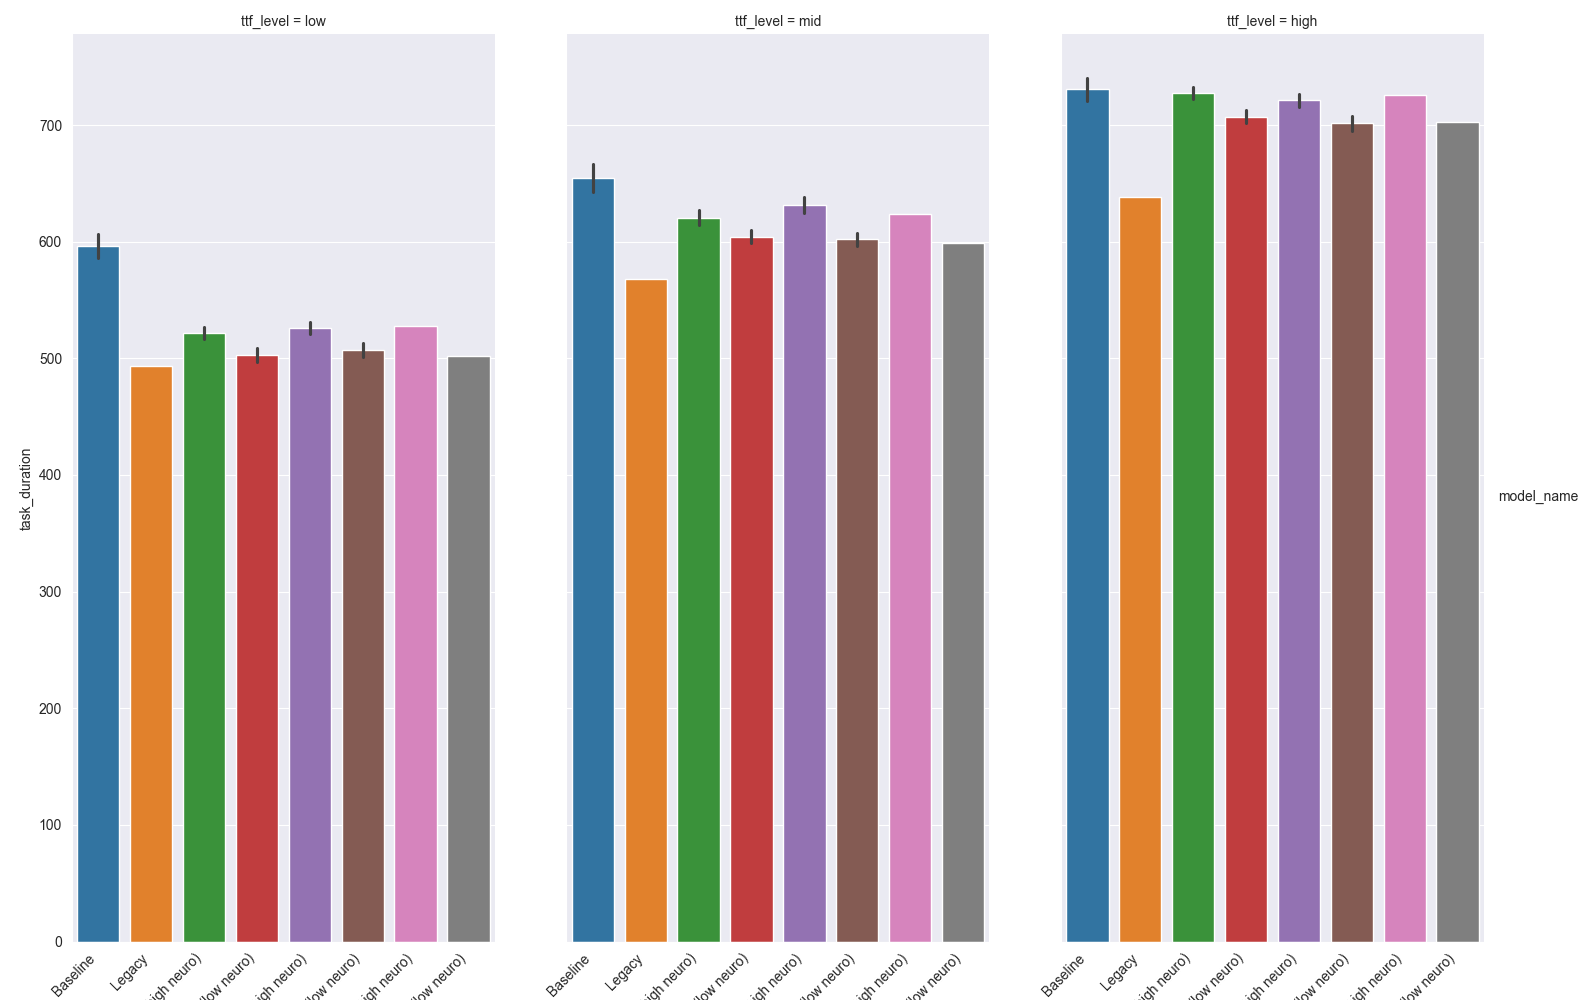

In [15]:
fg = sns.catplot(data=results[results["step_index"] == results["step_index"].max()], kind="bar", x="model_name", y="task_duration", hue="model_name", col="ttf_level", height=10, aspect=0.5)
for ax in fg.axes.flat:
    ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

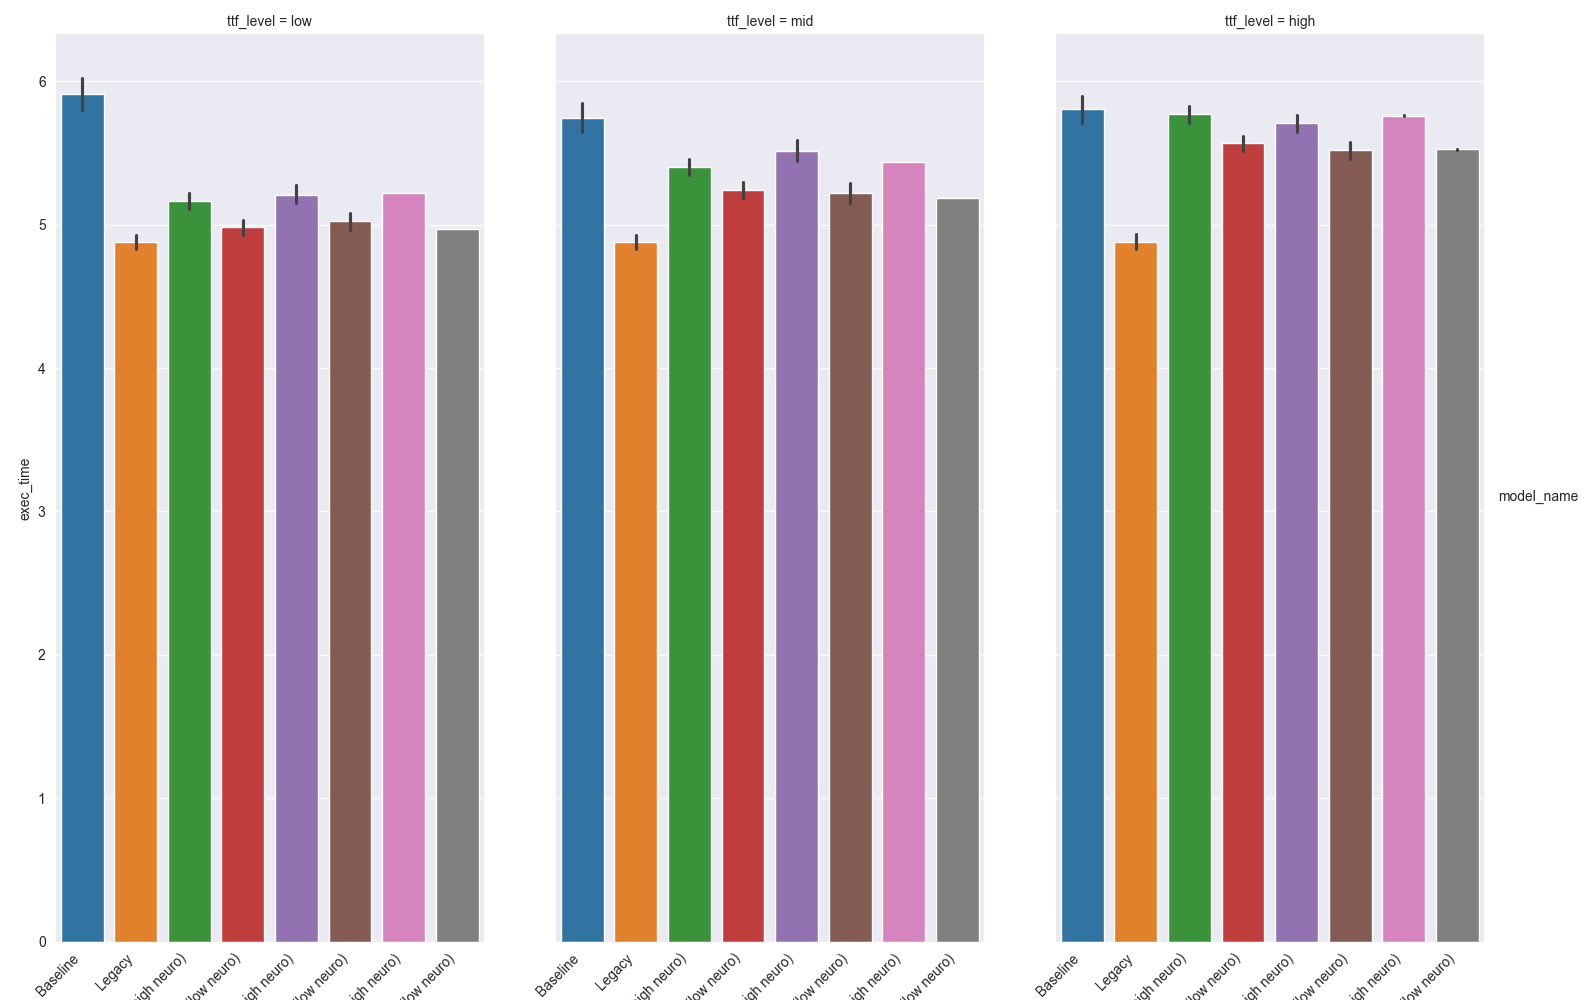

In [16]:
fg = sns.catplot(data=results, kind="bar", x="model_name", y="exec_time", hue="model_name", col="ttf_level", height=10, aspect=0.5)
for ax in fg.axes.flat:
    ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, ha='right')
plt.show()